## Examples of usage of geospatial_grid

See README.md for installation

Below some visualization parameters

In [5]:
# Define colormaps for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np


# Create colormap
cmap_snow = plt.cm.Blues_r.copy()
cmap_snow.set_under('black')   # for values < 1
cmap_snow.set_over('grey')     # for values > 100

# Normalization: only 1–100 use the colormap
norm_snow = colors.Normalize(vmin=1, vmax=100)

# Create colormap
cmap_dem = plt.cm.terrain.copy()
cmap_dem=colors.LinearSegmentedColormap.from_list('Blues_partial',cmap_dem(np.linspace(0.3, 1, 256)))
cmap_dem.set_under('grey')   # for values < 0
# Normalization: only 1–100 use the colormap
norm_dem = colors.Normalize(vmin=0, vmax=4000)


### Reproject xarray objects on a grid of your choice

Resolution of this Dataset:  (250.0, -250.0)


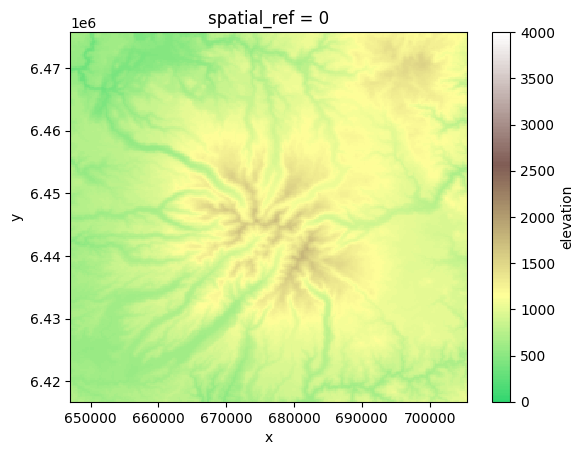

In [6]:
import xarray as xr
import matplotlib.pyplot as plt

dem_cantal = xr.open_dataset('../data/dem_cantal.tif')
# Clean dataset from "band" data structure crerated by default when opening a tif within xarray
dem_cantal = dem_cantal.sel(band=1).drop_vars('band').rename({'band_data':'elevation'})
dem_cantal.data_vars['elevation'].plot.imshow(cmap=cmap_dem, norm=norm_dem)
print("Resolution of this Dataset: ",dem_cantal.rio.resolution())

Let's suppose we want to reproject DEM at 250m resution to the MODIS SIN grid (see resource: https://modis-land.gsfc.nasa.gov/MODLAND_grid.html ) at a resolution that matches the VIIRS snow cover products products (see : https://nsidc.org/data/vnp10a1/versions/1)

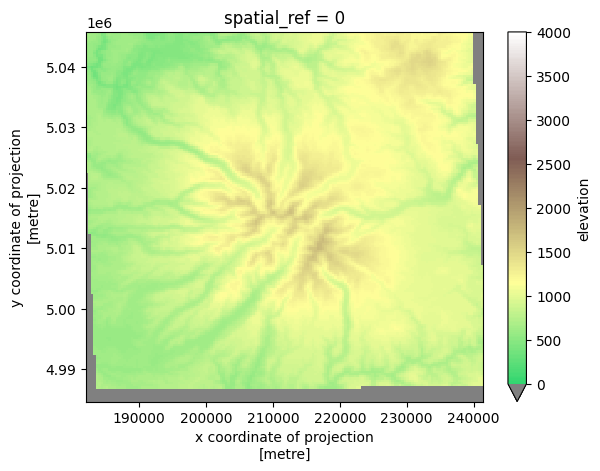

In [7]:
from pyproj import CRS
from geospatial_grid.gsgrid import GSGrid
from geospatial_grid.reprojections import reproject_using_grid
from rasterio.enums import Resampling
from pyproj import Transformer
# MODIS SIN grid has to be manually defined: 
PROJ4_MODIS = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +R=6371007.181 +units=m +no_defs"

snow_cover_cantal = xr.open_dataset('../data/fsc_cantal_viirs_jpss1.nc')

my_grid = GSGrid(
            crs=CRS.from_proj4(PROJ4_MODIS),
            resolution=370.650173222222,
            x0=snow_cover_cantal.coords['x'].values[0],
            y0=snow_cover_cantal.coords['y'].values[0],
            width=160,
            height=165,
            name="SIN_375m",
        )
reprojected_dem = reproject_using_grid(data=dem_cantal, output_grid=my_grid, nodata=-10000, resampling_method=Resampling.bilinear)
reprojected_dem.data_vars['elevation'].plot.imshow(cmap=cmap_dem, norm=norm_dem)

The above code snippet is equivalent to 

```
gdalwarp -q -overwrite -t_srs "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +R=6371007.181 +units=m +no_defs" -te 181935 4987057 241981 5045991 -srcnodata -10000 -r bilinear -tr 375 375 ../data/dem_cantal.tif ../data/dem_cantal_sin_grid_375m.tif
```

### Reuse grid objects for automazing reprojections within a pipeline

Let's supose we want to reproject a time series of VIIRS snow cover satellite observation (CRS: MODIS SIN grid) and a DEM (CRS: Lambert-93) on a UTM projection for comparison, for example, with a third source of data.

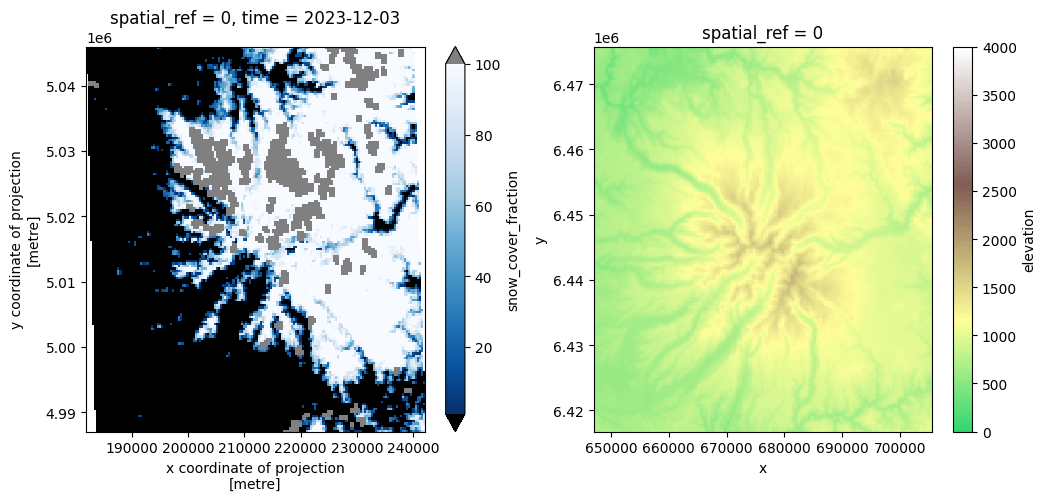

In [4]:
# In some module of your code
import xarray as xr
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(12,5))
snow_cover_cantal.data_vars['snow_cover_fraction'].sel(time='2023-12-03').plot.imshow(cmap=cmap_snow, norm=norm_snow, ax=axs[0])
dem_cantal.data_vars['elevation'].plot.imshow(cmap=cmap_dem, norm=norm_dem,  ax=axs[1])

We can define in some module of our code a Grid object that we can reuse multiple times when doing multiple projections on the same grid. Here we use the an instance of class UTM375mGridCantal defined in another module

In [5]:
# In some other module of your code
from geospatial_grid.grid_database import UTM375mGridCantal

reprojected_dem=reproject_using_grid(data=dem_cantal,output_grid=UTM375mGridCantal(),nodata=-10000, resampling_method=Resampling.bilinear)

In [6]:
# In another module of your code
reprojected_snow_cover=reproject_using_grid(data=snow_cover_cantal,output_grid=UTM375mGridCantal(),nodata=255, resampling_method=Resampling.nearest)

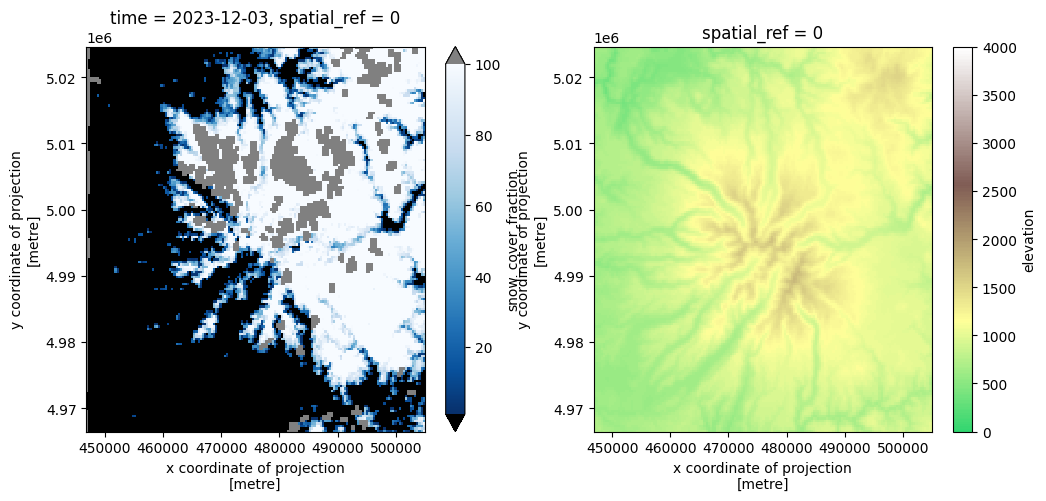

In [7]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
reprojected_snow_cover.data_vars['snow_cover_fraction'].sel(time='2023-12-03').plot.imshow(cmap=cmap_snow, norm=norm_snow, ax=axs[0])
reprojected_dem.data_vars['elevation'].plot.imshow(cmap=cmap_dem, norm=norm_dem,  ax=axs[1])